# Song Prediction

### Import Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/song-popularity-dataset/song_data.csv


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split as split
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pydot
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [5]:
songs_df = pd.read_csv('/kaggle/input/song-popularity-dataset/song_data.csv')
songs_df.head()

song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4          0.474  
1    -6.407           0       0.0498  105.256               4          0.370  
2    -7.828           1       0.0792  123.881               4          0.324  
3    -4.938           1       0.1070  122.444               4          0.198  
4    -5.065           1       0.0313  172.011               4          0.574

Now, let's explore the structure of the data file.

In [6]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [66]:
print('-' * 10 + 'BASIC INFORMATION' + '-' * 10 + '\n')

print('The number of rows is about: ' + "\033[1m" + str(songs_df.shape[0]) + "\033[0;0m")
print('The number of cols is about: ' + "\033[1m" + str(songs_df.shape[1]) + "\033[0;0m")
print('The number of data is about: ' + "\033[1m" + str(songs_df.shape[0] * songs_df.shape[1]) + "\033[0;0m" + '\n')

----------BASIC INFORMATION----------

The number of rows is about: 18835
The number of cols is about: 15
The number of data is about: 282525



In [68]:
print("--------------D-TYPES------------- " + '\n')
if len(songs_df.select_dtypes("object").columns) > 0:
    print("Object Variables:", "\n", "variables:",songs_df.select_dtypes("object").columns.tolist(), "\n")
if len(songs_df.select_dtypes("integer").columns) > 0:
    print("Integer Variables:", "\n", "variables:",songs_df.select_dtypes("integer").columns.tolist(), "\n")
if len(songs_df.select_dtypes("float").columns) > 0:
    print("Float Variables:", "\n", "variables:",songs_df.select_dtypes("float").columns.tolist(), "\n")
if len(songs_df.select_dtypes("bool").columns) > 0:
    print("Bool Variables:", "\n", "variables:", songs_df.select_dtypes("bool").columns.tolist(), "\n")

--------------D-TYPES------------- 

Object Variables: 
 variables: ['song_name'] 

Integer Variables: 
 variables: ['song_popularity', 'song_duration_ms', 'key', 'audio_mode', 'time_signature'] 

Float Variables: 
 variables: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence'] 



Let's see if we have null or empty values

In [7]:
#Check for null values
songs_df.isnull().values.any()

False

Seems like we have no empty values. 

In [70]:
clean_duplicated = songs_df.duplicated(subset = None, keep = 'first')
n_duplicated = clean_duplicated[clean_duplicated == True].shape[0]

print('There are ' + str(n_duplicated) + ' rows in the DataFrame.')
print('Its the same to say that the ' + "\033[1m" + str(round(((n_duplicated / songs_df.shape[0]) * 100), 2)) + "\033[0;0m" +
      '% of the data is duplicated')

There are 3909 rows in the DataFrame.
Its the same to say that the 20.75% of the data is duplicated


In [74]:
# Clean the duplicated data...

songs_df = songs_df.drop_duplicates(subset = None, keep = 'first')
print('Now we have: ' + "\033[1m" + str(18835 - 3909) + "\033[0;0m" + ' rows.')
songs_df

Now we have: 14926 rows.


song_name  song_popularity  song_duration_ms  \
0      Boulevard of Broken Dreams               73            262333   
1                      In The End               66            216933   
2               Seven Nation Army               76            231733   
3                      By The Way               74            216933   
4               How You Remind Me               56            223826   
...                           ...              ...               ...   
18830              Let It Breathe               60            159645   
18831                     Answers               60            205666   
18832      Sudden Love (Acoustic)               23            182211   
18833           Gentle on My Mind               55            352280   
18834                    Up to Me               60            193533   

       acousticness  danceability  energy  instrumentalness  key  liveness  \
0          0.005520         0.496   0.682          0.000029    8    0.0589   
1          0.010300         0.542   0.853          0.000000    3    0.1080   
2          0.008170         0.737   0.463          0.447000    0    0.2550   
3          0.026400         0.451   0.970          0.003550    0    0.1020   
4          0.000954         0.447   0.766          0.000000   10    0.1130   
...             ...           ...     ...               ...  ...       ...   
18830      0.893000         0.500   0.151          0.000065   11    0.1110   
18831      0.765000         0.495   0.161          0.000001   11    0.1050   
18832      0.847000         0.719   0.325          0.000000    0    0.1250   
18833      0.945000         0.488   0.326          0.015700    3    0.1190   
18834      0.911000         0.640   0.381          0.000254    4    0.1040   

       loudness  audio_mode  speechiness    tempo  time_signature  \
0        -4.095           1       0.0294  167.060               4   
1        -6.407           0       0.0498  105.256               4   
2        -7.828           1       0.0792  123.881               4   
3        -4.938           1       0.1070  122.444               4   
4        -5.065           1       0.0313  172.011               4   
...         ...         ...          ...      ...             ...   
18830   -16.107           1       0.0348  113.969               4   
18831   -14.078           0       0.0301   94.286               4   
18832   -12.222           1       0.0355  130.534               4   
18833   -12.020           1       0.0328  106.063               4   
18834   -11.790           1       0.0302   91.490               4   

       audio_valence  
0              0.474  
1              0.370  
2              0.324  
3              0.198  
4              0.574  
...              ...  
18830          0.300  
18831          0.265  
18832          0.286  
18833          0.323  
18834          0.581  

[14926 rows x 15 columns]

We can now explore pair plot of the date to understand the trends.

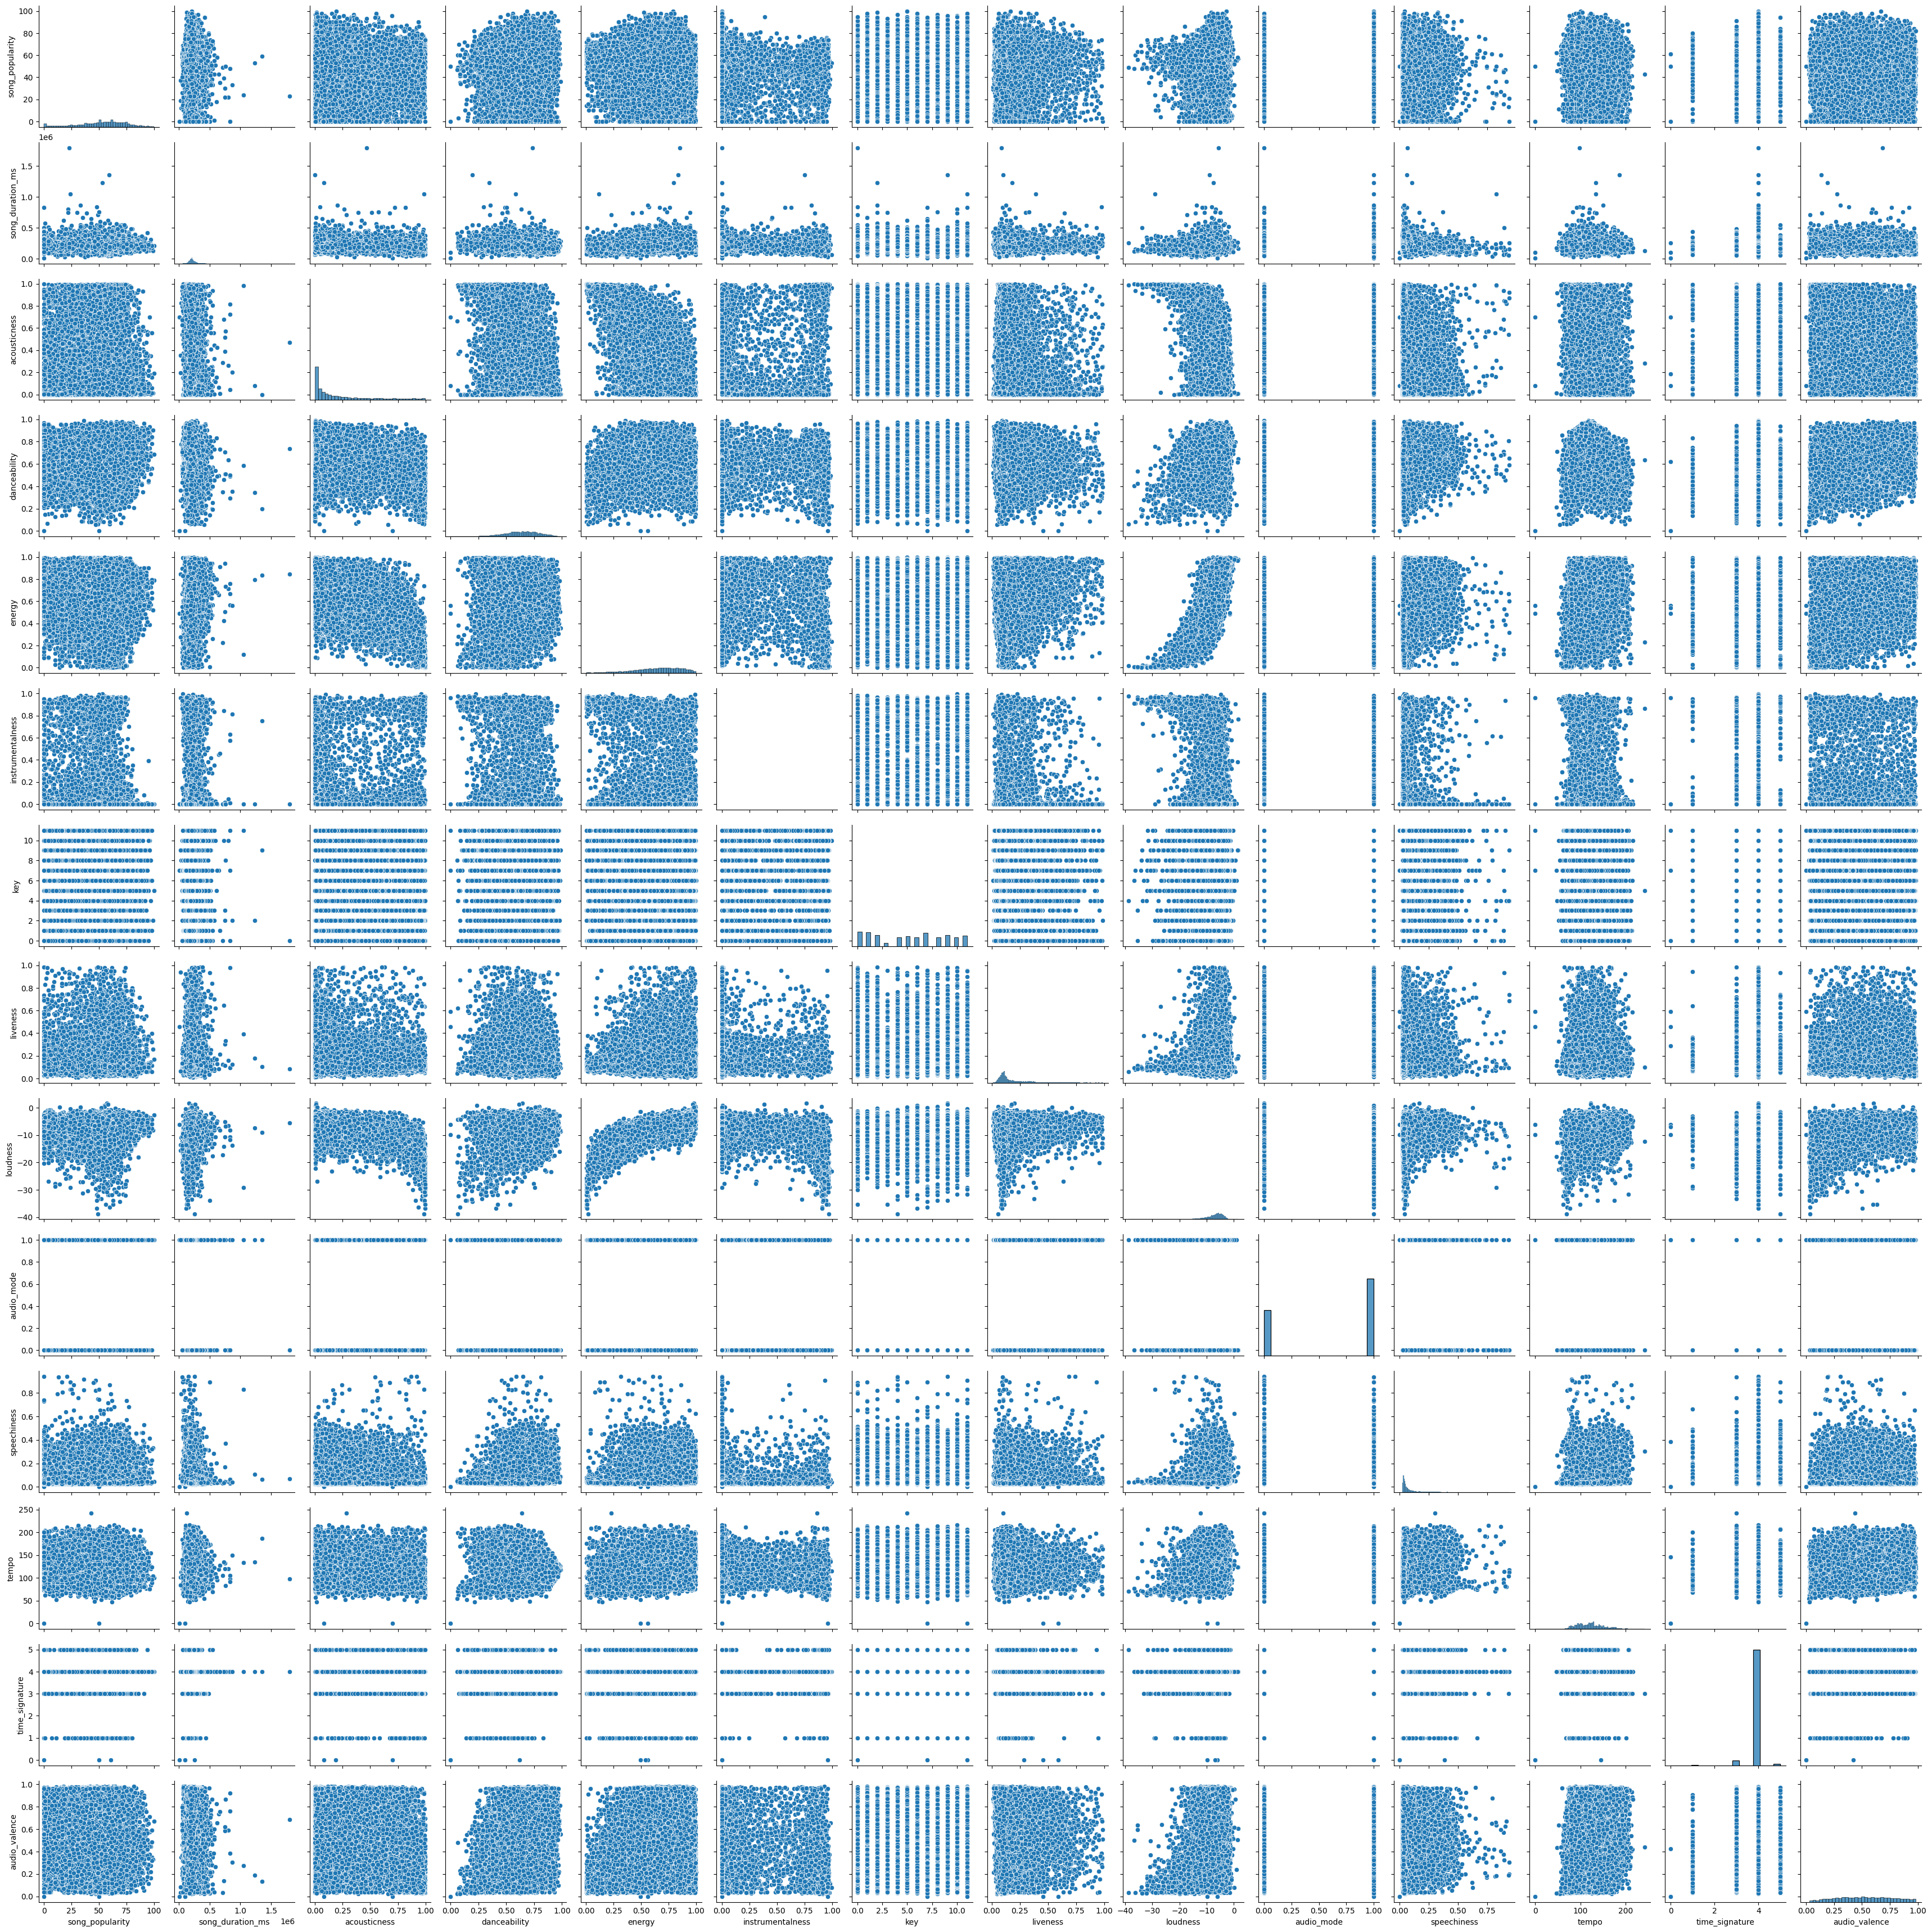

In [8]:
sns.pairplot(songs_df)

We cannot see in clear any correlation between the values. Let's try the correlations heatmap.

<AxesSubplot: >

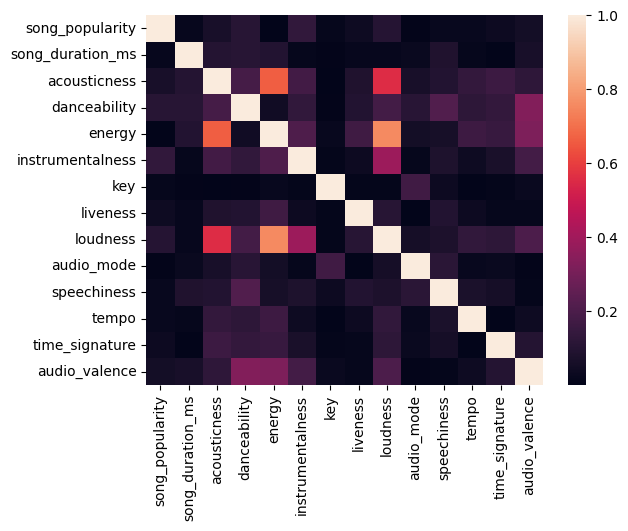

In [9]:
#find correlation in the data
corr = songs_df.corr().abs()
sns.heatmap(corr)

Now we can see something like the correlations. We'll explore some of the interestiong values as a histograms.

(array([8462., 2460., 1693., 1215.,  991.,  879.,  782.,  749.,  793.,
         811.]),
 array([1.02000000e-06, 9.96009180e-02, 1.99200816e-01, 2.98800714e-01,
        3.98400612e-01, 4.98000510e-01, 5.97600408e-01, 6.97200306e-01,
        7.96800204e-01, 8.96400102e-01, 9.96000000e-01]),
 <BarContainer object of 10 artists>)

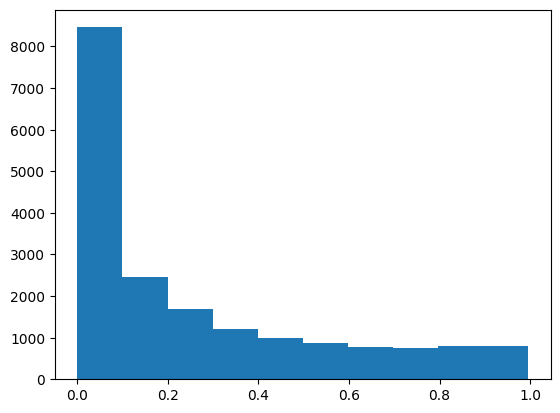

In [18]:
# acousticness values are between 0 to 1
plt.hist(songs_df.acousticness)

(array([ 262.,  451.,  761., 1116., 1927., 2656., 3097., 3366., 3150.,
        2049.]),
 array([0.00107 , 0.100863, 0.200656, 0.300449, 0.400242, 0.500035,
        0.599828, 0.699621, 0.799414, 0.899207, 0.999   ]),
 <BarContainer object of 10 artists>)

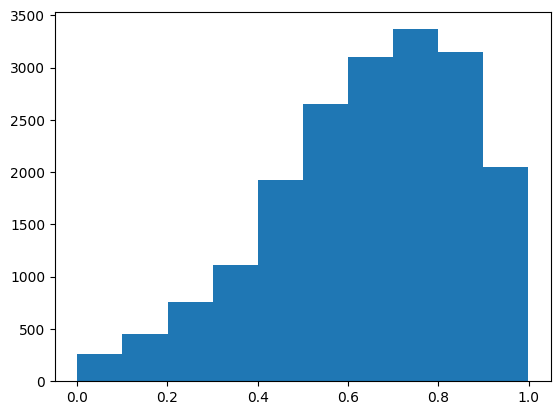

In [17]:
# energy values are between 0 to 1

plt.hist(songs_df.energy)

(array([6.000e+00, 1.700e+01, 4.300e+01, 8.600e+01, 1.940e+02, 5.170e+02,
        2.186e+03, 6.575e+03, 8.871e+03, 3.400e+02]),
 array([-38.768 , -34.7327, -30.6974, -26.6621, -22.6268, -18.5915,
        -14.5562, -10.5209,  -6.4856,  -2.4503,   1.585 ]),
 <BarContainer object of 10 artists>)

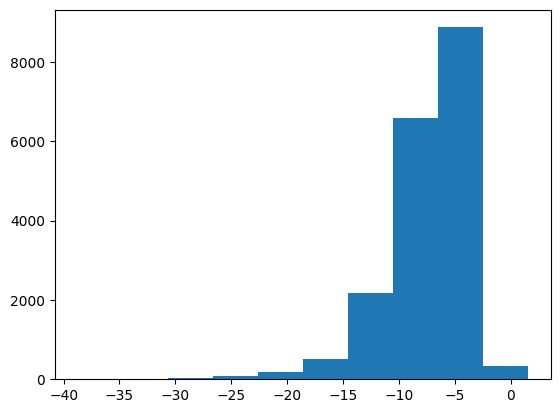

In [12]:
# loudness values are negative and not between 0 to 1

plt.hist(songs_df.loudness)

(array([16403.,   409.,   247.,   193.,   147.,   153.,   145.,   247.,
          436.,   455.]),
 array([0.    , 0.0997, 0.1994, 0.2991, 0.3988, 0.4985, 0.5982, 0.6979,
        0.7976, 0.8973, 0.997 ]),
 <BarContainer object of 10 artists>)

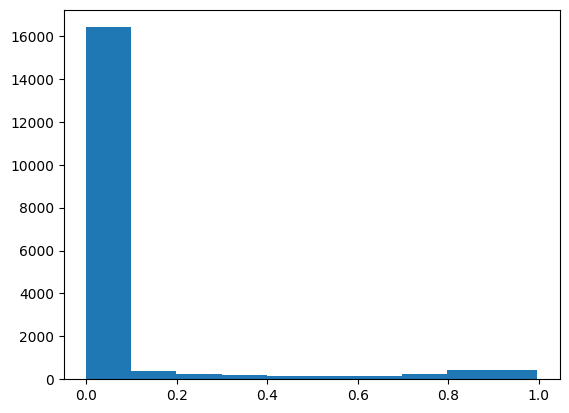

In [14]:
# instrumentalness values are between 0 to 1

plt.hist(songs_df.instrumentalness)

(array([7407., 6327., 2111., 1682.,  470.,  280.,  267.,  159.,   78.,
          54.]),
 array([0.0109 , 0.10841, 0.20592, 0.30343, 0.40094, 0.49845, 0.59596,
        0.69347, 0.79098, 0.88849, 0.986  ]),
 <BarContainer object of 10 artists>)

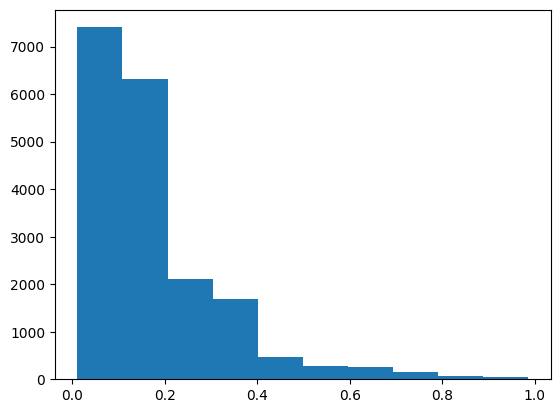

In [16]:
# liveness values are between 0 to 1

plt.hist(songs_df.liveness)

Now we can see that loudness should be recalibrated. We'll reflect this in our transformer.

In [19]:
class SongsPopularityTransformer():
    def __init__(self):
        pass
    def transform(self, db):
        db['loudness'] = db['loudness'].abs() #converting values to positive
        db['loudness'] = (db['loudness'] - np.min(db['loudness']))/(np.max(db['loudness']) - np.min(db['loudness']))
        #scaling values range to be between 0 and 1
        db = db[['song_popularity', 'acousticness','energy', 'loudness', 'instrumentalness', 'liveness']]
        return db

In [78]:
top_songs = songs_df.sort_values('song_popularity', ascending = False).head(15)

fig = px.bar(top_songs, x = 'song_popularity', y = 'song_name', orientation = 'h', color = 'song_name', text_auto = True)
fig.update_layout(title_text = 'Top 15 most popular songs')

fig.show()

In [80]:
not_top_songs = songs_df.loc[songs_df['song_popularity'] > 0].sort_values('song_popularity', ascending = True).head(15)

fig = px.bar(not_top_songs, x = 'song_popularity', y = 'song_name', orientation = 'h', color = 'song_name', text_auto = True)
fig.update_layout(title_text = 'Top 15 less popular songs')

fig.show()


Text(0, 0.5, 'COUNT')

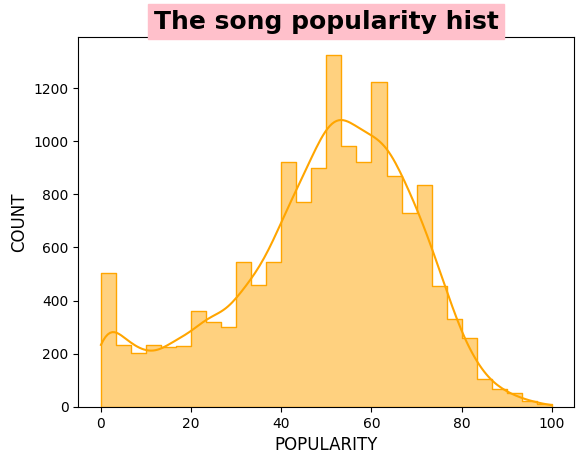

In [81]:
sns.histplot(songs_df['song_popularity'], kde = True, element = 'step', bins = 30, color = 'orange')
sns.set_style('darkgrid')

plt.title('The song popularity hist', fontsize = 18, fontweight = 'bold', backgroundcolor = 'pink')
plt.xlabel('POPULARITY', fontsize = 12)
plt.ylabel('COUNT', fontsize = 12)

### Modelling

Now we'll create our test, validation and training data sets.

In [20]:
#split the data
songs_train, songs_test = split(songs_df, train_size=0.7, random_state=433)
songs_valid, songs_test = split(songs_test, train_size=0.5, random_state=433)

Let's transform them.

In [21]:
#transforming the data
songs_transformer = SongsPopularityTransformer()
songs_train_trans = songs_transformer.transform(songs_train)
songs_valid_trans = songs_transformer.transform(songs_valid)
songs_test_trans = songs_transformer.transform(songs_valid)

Here we go!! Let;s train our Linear Regression model.

In [23]:
#Linear regression model
songs_lm = LinearRegression()
X_train = songs_train_trans.drop('song_popularity', axis=1)
y_train = songs_train_trans['song_popularity']

songs_lm.fit(X_train, y_train)

LinearRegression()

Now we can extrach linear function from our model.

In [24]:
print("The model intercept is: {}".format(songs_lm.intercept_))
print("The model Coefficients are: {}".format(songs_lm.coef_[0]))
formula = 'Song popularity = ' + f'{songs_lm.intercept_:.3f}'
for coef, feature in zip(songs_lm.coef_, songs_train_trans.columns[1:-1]):
    formula += f'{coef:+.3f}*{feature}'
print(formula)

The model intercept is: 76.30239866306616
The model Coefficients are: -7.72046492679186
Song popularity = 76.302-7.720*acousticness-19.882*energy-35.320*loudness-8.940*instrumentalness


Now, let's predict the train set.

In [25]:
songs_train_trans = songs_train_trans.merge(pd.Series(songs_lm.predict(X_train)).rename('popularity_pred'),
             left_index=True, right_index=True)
songs_train_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
7494                69        0.0267   0.628  0.126537          0.000004   
8956                 3        0.0089   0.944  0.107206          0.000000   
10021               70        0.4750   0.607  0.117103          0.000000   
3582                60        0.0114   0.713  0.149085          0.018300   
10242               39        0.6580   0.638  0.227145          0.839000   

       liveness  popularity_pred  
7494     0.1190        53.864931  
8956     0.1730        54.395316  
10021    0.0812        54.574321  
3582     0.0608        59.680218  
10242    0.1410        58.332070

Lets measure RMSE for the train set.

In [26]:
rmse_train = np.sqrt(mean_squared_error(songs_train_trans['popularity_pred'], songs_train_trans['song_popularity']))
print(f"RMSE = {rmse_train:.2f}")


RMSE = 21.87


Now, we'll validate the model.

In [27]:
X_valid = X_train = songs_valid_trans.drop('song_popularity', axis=1)
songs_valid_trans_pred = songs_lm.predict(X_valid)
                                          
songs_valid_trans = songs_valid_trans.merge(pd.Series(songs_valid_trans_pred).rename('popularity_pred'),left_index=True, right_index=True)
songs_valid_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
301                66        0.4650   0.483  0.119683          0.497000   
2167               74        0.6000   0.472  0.226621          0.000004   
470                72        0.4990   0.350  0.386648          0.000008   
1017                5        0.0328   0.771  0.152909          0.000001   
1034               52        0.0187   0.666  0.149955          0.692000   

      liveness  popularity_pred  
301     0.0686        56.054324  
2167    0.3170        52.719474  
470     0.0844        51.838627  
1017    0.0594        49.292888  
1034    0.1120        53.574185

And measure the RMSE for validation set.

In [28]:
rmse_valid = np.sqrt(mean_squared_error(songs_valid_trans['popularity_pred'], songs_valid_trans['song_popularity']))
print(f"RMSE = {rmse_valid:.2f}")

RMSE = 21.00


Ok. Time to test our model.

In [29]:
X_test = X_train = songs_test_trans.drop('song_popularity', axis=1)
songs_test_trans_pred = songs_lm.predict(X_test)
                                          
songs_test_trans = songs_test_trans.merge(pd.Series(songs_test_trans_pred).rename('popularity_pred'),left_index=True, right_index=True)
songs_test_trans.head()

song_popularity  acousticness  energy  loudness  instrumentalness  \
301                66        0.4650   0.483  0.119683          0.497000   
2167               74        0.6000   0.472  0.226621          0.000004   
470                72        0.4990   0.350  0.386648          0.000008   
1017                5        0.0328   0.771  0.152909          0.000001   
1034               52        0.0187   0.666  0.149955          0.692000   

      liveness  popularity_pred  
301     0.0686        56.054324  
2167    0.3170        52.719474  
470     0.0844        51.838627  
1017    0.0594        49.292888  
1034    0.1120        53.574185

And measure RMSE for the test set.

In [30]:
rmse_test = np.sqrt(mean_squared_error(songs_test_trans['popularity_pred'], songs_test_trans['song_popularity']))
print(f"RMSE = {rmse_test:.2f}")

RMSE = 21.00


Done. Let's compare RMSE's:

In [31]:
print(f'rmse scores: Train - {rmse_train:.2f}, Valid - {rmse_valid:.2f} and Test - {rmse_test:.2f}')

rmse scores: Train - 21.87, Valid - 21.00 and Test - 21.00


Now' let's move to train another model, based on Decision Tree Regression.

In [32]:
# Decision tree regression

songs_train, songs_test = split(songs_df, train_size=0.7, random_state=433)
songs_valid, songs_test = split(songs_test, train_size=0.5, random_state=433)

songs_transformer = SongsPopularityTransformer()
songs_train_trans = songs_transformer.transform(songs_train)
songs_valid_trans = songs_transformer.transform(songs_valid)
songs_test_trans = songs_transformer.transform(songs_valid)

After preparing the train, validation and test data, let's fit the model. We'll choose max of 5 leaf nodes.

In [33]:
tree_model_5 = DecisionTreeRegressor(max_leaf_nodes=5)

X_train = songs_train_trans.drop('song_popularity', axis=1)
y_train = songs_train_trans['song_popularity']
tree_model_5.fit(X_train,y_train)
y_pred = tree_model_5.predict(X_train)

Let's present the tree.

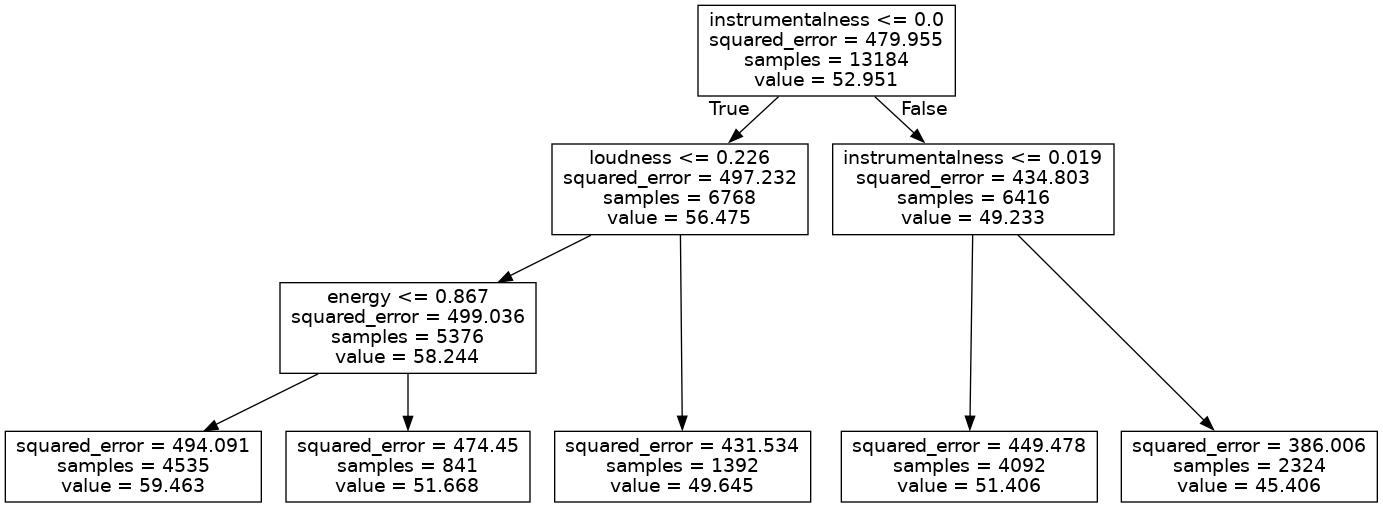

In [34]:
dot_data = StringIO()  
export_graphviz(tree_model_5, out_file=dot_data, feature_names=X_train.columns, leaves_parallel=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=750) 

Now, we'll measure the RMSE for training data.

In [35]:
rmse_des_tree_5_train = np.sqrt(mean_squared_error(y_pred, y_train))
print(f"RMSE = {rmse_des_tree_5_train:.2f}")

RMSE = 21.29


Ok. We can validate our model.

In [37]:
X_valid = songs_valid_trans.drop('song_popularity', axis=1)
y_valid = songs_valid_trans['song_popularity']
y_valid_pred = tree_model_5.predict(X_valid)

rmse_des_tree_5_valid = np.sqrt(mean_squared_error(y_valid_pred, y_valid))
print(f"RMSE = {rmse_des_tree_5_valid:.2f}")

RMSE = 21.63


And test it.

In [38]:
X_test = songs_valid_trans.drop('song_popularity', axis=1)
y_test = songs_valid_trans['song_popularity']
y_test_pred = tree_model_5.predict(X_test)

rmse_des_tree_5_test = np.sqrt(mean_squared_error(y_test_pred, y_test))
print(f"RMSE = {rmse_des_tree_5_test:.2f}")

RMSE = 21.63


Now, we'll compare the RMSE for all stages.

In [40]:
print(f'rmse scores: Train - {rmse_des_tree_5_train:.2f}, Valid - {rmse_des_tree_5_valid:.2f} and Test - {rmse_des_tree_5_test:.2f}')

rmse scores: Train - 21.29, Valid - 21.63 and Test - 21.63


Now, we can train a new model with more leaf nodes.

In [41]:
tree_model_15 = DecisionTreeRegressor(max_leaf_nodes=15)

X_train_15 = songs_train_trans.drop('song_popularity', axis=1)
y_train_15 = songs_train_trans['song_popularity']
tree_model_15.fit(X_train_15,y_train_15)
y_pred_15 = tree_model_15.predict(X_train_15)

We'll also print the tree.

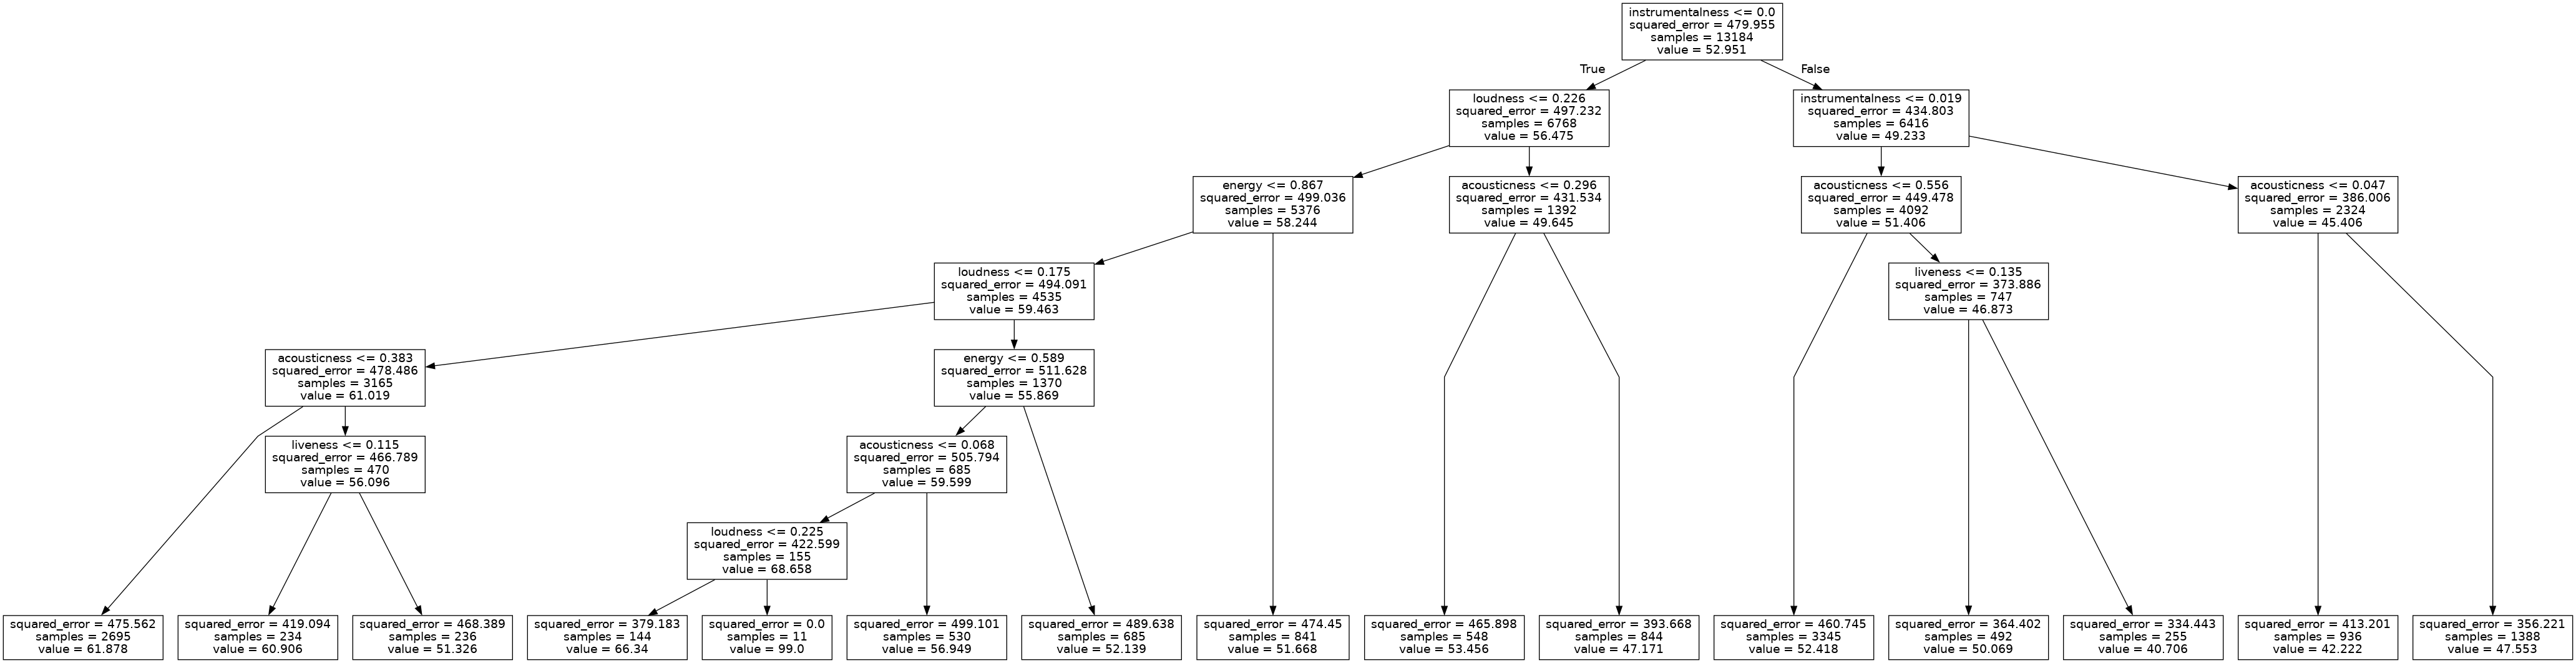

In [42]:
dot_data_15 = StringIO()  
export_graphviz(tree_model_15, out_file=dot_data_15, feature_names=X_train_15.columns, leaves_parallel=True)  
graph = pydot.graph_from_dot_data(dot_data_15.getvalue())[0]  
Image(graph.create_png(), width=750) 

In [43]:
rmse_des_tree_15_train = np.sqrt(mean_squared_error(y_pred_15, y_train_15))
print(f"RMSE = {rmse_des_tree_15_train:.2f}")

RMSE = 21.01


After that, we can validate the model.

In [44]:
X_valid_15 = songs_valid_trans.drop('song_popularity', axis=1)
y_valid_15 = songs_valid_trans['song_popularity']
y_valid_pred_15 = tree_model_15.predict(X_valid_15)

rmse_des_tree_15_valid = np.sqrt(mean_squared_error(y_valid_pred_15, y_valid_15))
print(f"RMSE = {rmse_des_tree_15_valid:.2f}")

RMSE = 21.49


And test it.

In [46]:
X_test_15 = songs_valid_trans.drop('song_popularity', axis=1)
y_test_15 = songs_valid_trans['song_popularity']
y_test_pred_15 = tree_model_15.predict(X_test_15)

rmse_des_tree_15_test = np.sqrt(mean_squared_error(y_test_pred_15, y_test_15))
print(f"RMSE = {rmse_des_tree_15_test:.2f}")

RMSE = 21.49


Let's compare the results.

In [47]:
print(f'rmse scores: Train - {rmse_des_tree_15_train:.2f}, Valid - {rmse_des_tree_15_valid:.2f} and Test - {rmse_des_tree_15_test:.2f}')

rmse scores: Train - 21.01, Valid - 21.49 and Test - 21.49


Good. Let's try the Knn Regression.

In [48]:
#Knn regression

songs_train, songs_test = split(songs_df, train_size=0.7, random_state=433)
songs_valid, songs_test = split(songs_test, train_size=0.5, random_state=433)

songs_transformer = SongsPopularityTransformer()
songs_train_trans = songs_transformer.transform(songs_train)
songs_valid_trans = songs_transformer.transform(songs_valid)
songs_test_trans = songs_transformer.transform(songs_valid)

We got the data, time to train our first Knn model on 5 neighbors.

In [49]:
X_train_5 = songs_train_trans.drop('song_popularity', axis=1)
y_train_5 = songs_train_trans['song_popularity']

knn5 = KNeighborsRegressor(5)
knn5.fit(X_train_5,y_train_5)
y_train_pred_5 = knn5.predict(X_train_5)

rmse_knn_5_train = np.sqrt(mean_squared_error(y_train_pred_5, y_train_5))
print(f"RMSE = {rmse_knn_5_train:.2f}")

RMSE = 17.04


After fitting we'll validate the model.

In [50]:
X_valid_5 = songs_valid_trans.drop('song_popularity', axis=1)
y_valid_5 = songs_valid_trans['song_popularity']
y_valid_pred_5 = knn5.predict(X_valid_5)

rmse_knn_5_valid = np.sqrt(mean_squared_error(y_valid_pred_5, y_valid_5))
print(f"RMSE = {rmse_knn_5_valid:.2f}")

RMSE = 21.76


And test it.

In [51]:
X_test_5 = songs_valid_trans.drop('song_popularity', axis=1)
y_test_5 = songs_valid_trans['song_popularity']
y_test_pred_5 = knn5.predict(X_test_5)

rmse_knn_5_test = np.sqrt(mean_squared_error(y_test_pred_5, y_test_5))
print(f"RMSE = {rmse_knn_5_test:.2f}")

RMSE = 21.76


And the result:

In [52]:
print(f'rmse scores: Train - {rmse_knn_5_train:.2f}, Valid - {rmse_knn_5_valid:.2f} and Test - {rmse_knn_5_test:.2f}')

rmse scores: Train - 17.04, Valid - 21.76 and Test - 21.76


Let's increate number of neighbors to 20.

In [53]:
#Knn 20
X_train_20 = songs_train_trans.drop('song_popularity', axis=1)
y_train_20 = songs_train_trans['song_popularity']

knn20 = KNeighborsRegressor(20)
knn20.fit(X_train_20,y_train_20)
y_train_pred_20 = knn20.predict(X_train_20)

rmse_knn_20_train = np.sqrt(mean_squared_error(y_train_pred_20, y_train_20))
print(f"RMSE = {rmse_knn_20_train:.2f}")

RMSE = 20.06


Validation:

In [54]:
X_valid_20 = songs_valid_trans.drop('song_popularity', axis=1)
y_valid_20 = songs_valid_trans['song_popularity']
y_valid_pred_20 = knn20.predict(X_valid_20)

rmse_knn_20_valid = np.sqrt(mean_squared_error(y_valid_pred_20, y_valid_20))
print(f"RMSE = {rmse_knn_20_valid:.2f}")

RMSE = 21.37


And the test:

In [55]:
X_test_20 = songs_valid_trans.drop('song_popularity', axis=1)
y_test_20 = songs_valid_trans['song_popularity']
y_test_pred_20 = knn20.predict(X_test_20)

rmse_knn_20_test = np.sqrt(mean_squared_error(y_test_pred_20, y_test_20))
print(f"RMSE = {rmse_knn_20_test:.2f}")

RMSE = 21.37


Now, the result:

In [56]:
print(f'rmse scores: Train - {rmse_knn_20_train:.2f}, Valid - {rmse_knn_20_valid:.2f} and Test - {rmse_knn_20_test:.2f}')

rmse scores: Train - 20.06, Valid - 21.37 and Test - 21.37


The last, but not the least, Knn on 50 neighbors.

In [57]:
#Knn 50
X_train_50 = songs_train_trans.drop('song_popularity', axis=1)
y_train_50 = songs_train_trans['song_popularity']

knn50 = KNeighborsRegressor(50)
knn50.fit(X_train_50,y_train_50)
y_train_pred_50 = knn50.predict(X_train_50)

rmse_knn_50_train = np.sqrt(mean_squared_error(y_train_pred_50, y_train_50))
print(f"RMSE = {rmse_knn_50_train:.2f}")

RMSE = 20.69


We'll validate:

In [58]:
X_valid_50 = songs_valid_trans.drop('song_popularity', axis=1)
y_valid_50 = songs_valid_trans['song_popularity']
y_valid_pred_50 = knn50.predict(X_valid_50)

rmse_knn_50_valid = np.sqrt(mean_squared_error(y_valid_pred_50, y_valid_50))
print(f"RMSE = {rmse_knn_50_valid:.2f}")

RMSE = 21.40


And test:

In [59]:
X_test_50 = songs_valid_trans.drop('song_popularity', axis=1)
y_test_50 = songs_valid_trans['song_popularity']
y_test_pred_50 = knn50.predict(X_test_50)

rmse_knn_50_test = np.sqrt(mean_squared_error(y_test_pred_50, y_test_50))
print(f"RMSE = {rmse_knn_50_test:.2f}")

RMSE = 21.40


Now, the result:

In [64]:
print(f'rmse scores: Train - {rmse_knn_50_train:.2f}, Valid - {rmse_knn_50_valid:.2f} and Test - {rmse_knn_50_test:.2f}')

rmse scores: Train - 20.69, Valid - 21.40 and Test - 21.40


Now we'll compare all models result together

In [65]:
linear_reg_results =  pd.Series({ "train": rmse_train, "validation": rmse_valid, "test": rmse_test }, name="Linear Regression")
desicion_tree_5_results = pd.Series({ "train": rmse_des_tree_5_train, "validation": rmse_des_tree_5_valid, "test": rmse_des_tree_5_test }, name="Desicion Tree 5")
desicion_tree_15_results = pd.Series({ "train": rmse_des_tree_15_train, "validation": rmse_des_tree_15_valid, "test": rmse_des_tree_15_test }, name="Desicion Tree 15")
knn_5_results = pd.Series({ "train": rmse_knn_5_train, "validation": rmse_knn_5_valid, "test": rmse_knn_5_test }, name="KNN 5")
knn_20_results = pd.Series({ "train": rmse_knn_20_train, "validation": rmse_knn_20_valid, "test": rmse_knn_20_test }, name="KNN 20")
knn_50_results = pd.Series({ "train": rmse_knn_50_train, "validation": rmse_knn_50_valid, "test": rmse_knn_50_test }, name="KNN 50")

results = pd.DataFrame([linear_reg_results, desicion_tree_5_results, desicion_tree_15_results, knn_5_results, knn_20_results, knn_50_results])
results

train  validation       test
Linear Regression  21.872827   21.001382  21.001382
Desicion Tree 5    21.291632   21.631133  21.631133
Desicion Tree 15   21.007516   21.491655  21.491655
KNN 5              17.041453   21.763495  21.763495
KNN 20             20.056094   21.367178  21.367178
KNN 50             20.691981   21.396637  21.396637